In [80]:
import os
import shutil
import subprocess
import urllib.request
import zipfile
from pathlib import Path
import pickle
import sys

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.colors import ListedColormap
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from umap import UMAP
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [81]:
pip show sentence-transformers faiss-cpu umap-learn pickle joblib

Name: sentence-transformers
Version: 2.6.1
Summary: Multilingual text embeddings
Home-page: https://www.SBERT.net
Author: Nils Reimers
Author-email: info@nils-reimers.de
License: Apache License 2.0
Location: C:\Users\kbged\Miniconda3\envs\py311p1\Lib\site-packages
Requires: huggingface-hub, numpy, Pillow, scikit-learn, scipy, torch, tqdm, transformers
Required-by: 
---
Name: faiss-cpu
Version: 1.8.0
Summary: A library for efficient similarity search and clustering of dense vectors.
Home-page: 
Author: 
Author-email: Kota Yamaguchi <yamaguchi_kota@cyberagent.co.jp>
License: MIT License
Location: C:\Users\kbged\Miniconda3\envs\py311p1\Lib\site-packages
Requires: numpy
Required-by: 
---
Name: umap-learn
Version: 0.5.5
Summary: Uniform Manifold Approximation and Projection
Home-page: http://github.com/lmcinnes/umap
Author: 
Author-email: 
License: BSD
Location: C:\Users\kbged\Miniconda3\envs\py311p1\Lib\site-packages
Requires: numba, numpy, pynndescent, scikit-learn, scipy, tqdm
Required-b

In [82]:
# Add the path to the other directory to the Python path
sys.path.append(os.path.abspath('../'))

In [179]:
from src.configs.config import ModelConfig, PathsConfig
from src.utils.file_ops import FilesOps
from src.utils.preprocessing_ops import PreprocessUtils
from src.utils.models import Models
from src.utils.plots import Plotter
from src.utils.reco_update import RecoUpdate
from src.utils.data_info import DataInfo

In [180]:
del sys.modules['src.configs.config'] 
del sys.modules['src.utils.file_ops'] 
del sys.modules['src.utils.preprocessing_ops']
del sys.modules['src.utils.models']
del sys.modules['src.utils.plots']
del sys.modules['src.utils.reco_update']
del sys.modules['src.utils.data_info']

In [181]:
from src.configs.config import ModelConfig, PathsConfig
from src.utils.file_ops import FilesOps
from src.utils.preprocessing_ops import PreprocessUtils
from src.utils.models import Models
from src.utils.plots import Plotter
from src.utils.reco_update import RecoUpdate
from src.utils.data_info import DataInfo

In [182]:
#Import path and model configs
path  = PathsConfig()
model = ModelConfig()

In [183]:
#Download the data (csv files of clean, drink, chocolate stuffs)
FilesOps.download_rename_and_unzip("https://www.dropbox.com/scl/fi/lt7mbtho9d3n9guh9cz2k/coopdata.zip?rlkey=m501w6zggiugila3zps1jfbql&dl=0", 'data.zip')

In [184]:
#Get info of all three csv files
data_info = DataInfo()
data_info.get_column_info(path.choco_data)
data_info.get_column_info(path.drink_data)
data_info.get_column_info(path.clean_data)

,Column Name,Null Values,Total Values,Column Type
0,web-scraper-order,0,60,object
1,web-scraper-start-url,0,60,object
2,title,0,60,object
3,price,0,60,float64
4,rating,0,60,object
5,quantity,0,60,object


,Column Name,Null Values,Total Values,Column Type
0,web-scraper-order,0,55,object
1,web-scraper-start-url,0,55,object
2,title,6,55,object
3,rating,0,55,object
4,quantity,0,55,object
5,price,0,55,object


,Column Name,Null Values,Total Values,Column Type
0,web-scraper-order,0,60,object
1,web-scraper-start-url,0,60,object
2,title,0,60,object
3,quantity,0,60,object
4,price,0,60,float64
5,rating,0,60,object


In [185]:
#Preprocess all dataframe
choco_emb  = PreprocessUtils.preprocess_dataframe(path.choco_data, model.model, 'choco')
drink_emb  = PreprocessUtils.preprocess_dataframe(path.drink_data, model.model, 'drink')
clean_emb  = PreprocessUtils.preprocess_dataframe(path.clean_data, model.model, 'clean')

#Make one common input dataframe and add 786 dim embeddings corresponding to name of a product
preprocced_df = PreprocessUtils.concat_dataframe([clean_emb, drink_emb, choco_emb])
preprocced_df = PreprocessUtils.split_embeddings(preprocced_df)

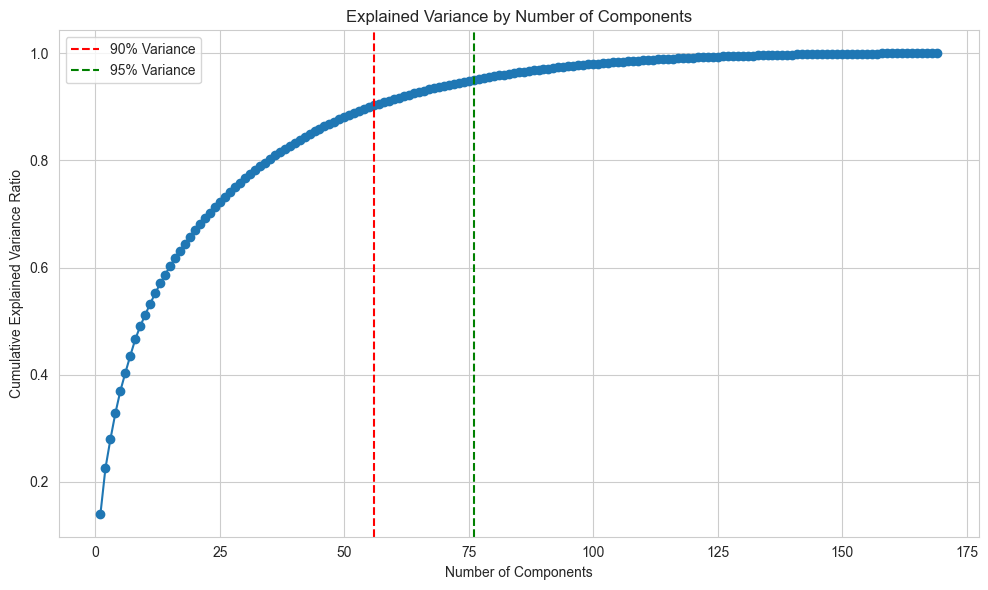

Number of components explaining 90% variance: 56
Number of components explaining 95% variance: 76


In [186]:
models = Models(preprocced_df)

#Trying to find optimal number of PCA components to reduce 786 dim embedding vector
models.check_pca(embedding_prefix='embedding_')

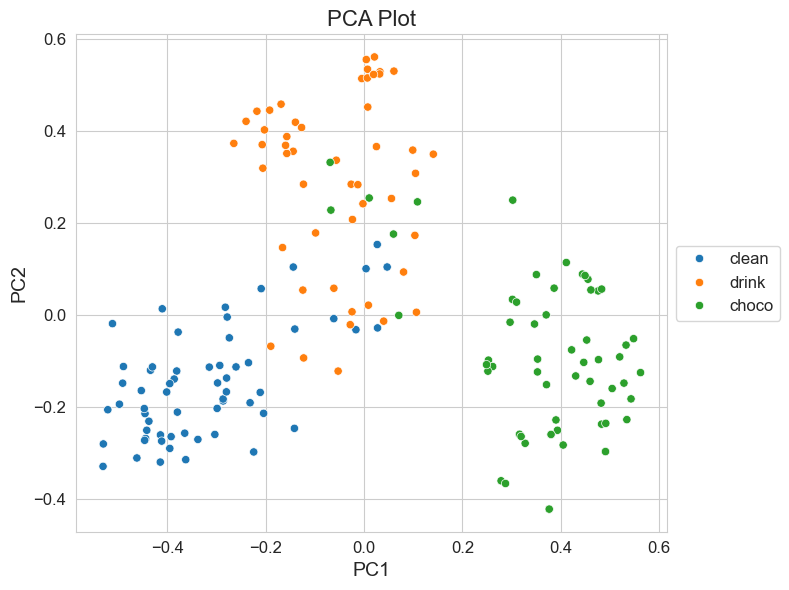

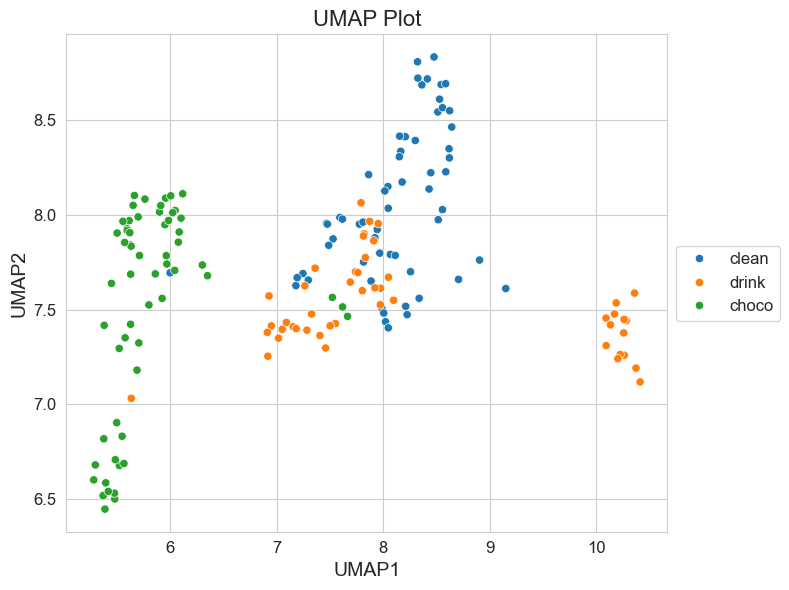

In [187]:
#Try reducing 786 embedding dimension into 6 pca components and 6 umap components

n_components_pca = 6
emb_split_df, _ = models.apply_pca(embedding_prefix='embedding_',n_components=n_components_pca)
Plotter.plot_pca(emb_split_df, filename='pca_'+str(n_components_pca)+'.png')

n_components_umap = 6
emb_split_df, _ = models.apply_umap(embedding_prefix='embedding_',n_components=n_components_umap)
Plotter.plot_umap(emb_split_df, filename='umap_'+str(n_components_pca)+'.png')

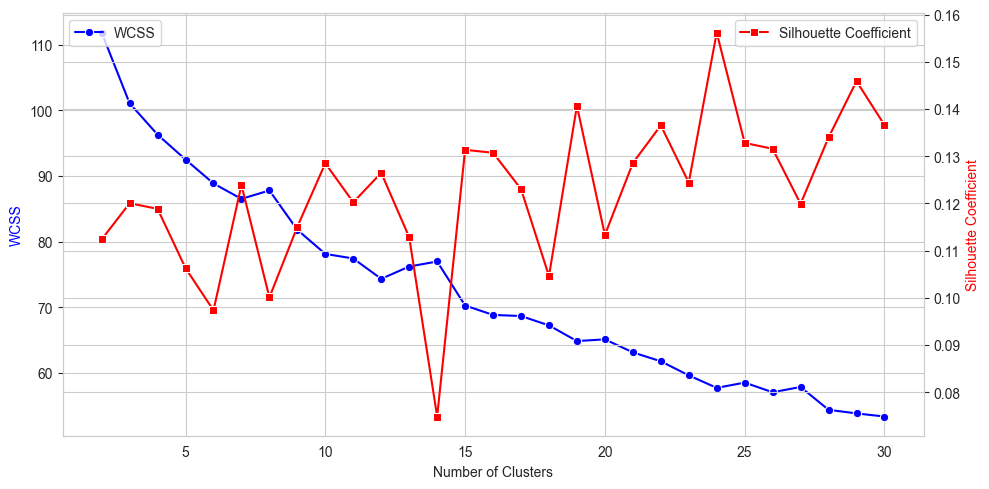

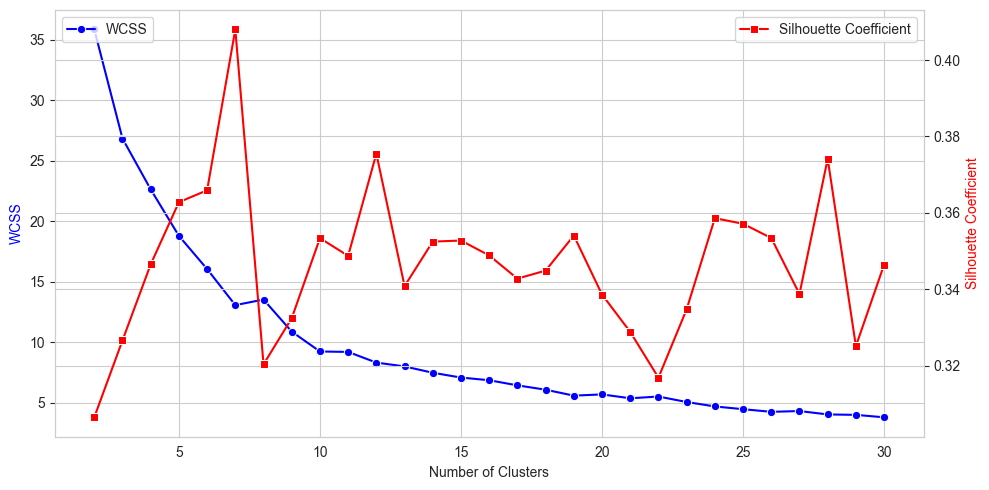

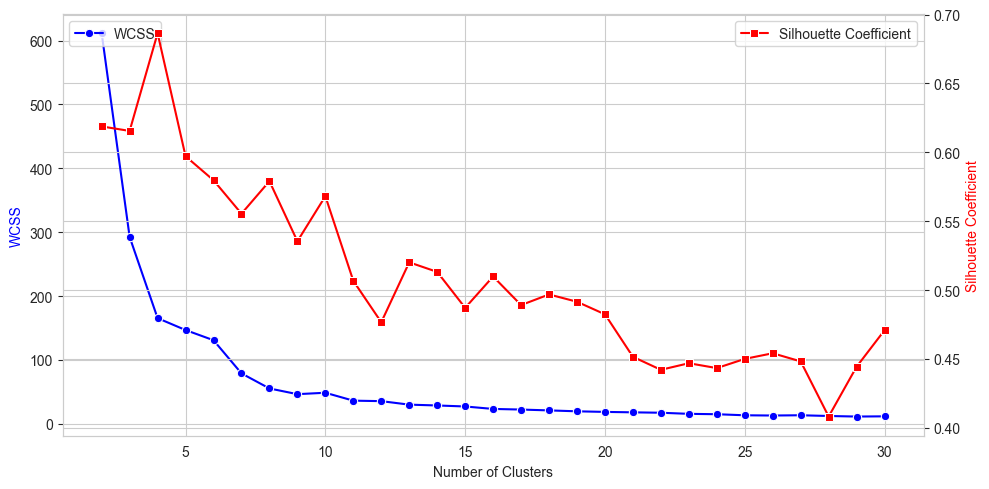

In [188]:
# Find optimal number kmeans cluster for each of the three cases:

#Case 1: 786 embedding vector
Plotter.cluster_and_plot(min_clusters=2, max_clusters=30, embedding_prefix='embedding_', df=emb_split_df, filename='Silhouette_emb.png')

#Case 2: PCA components
Plotter.cluster_and_plot(min_clusters=2, max_clusters=30, embedding_prefix='PC', df=emb_split_df, filename='PCA_emb.png')

#Case 3: UMAP components-> This is used to reduce dimension for spectral clustering in this study
Plotter.cluster_and_plot(min_clusters=2, max_clusters=30, embedding_prefix='UMAP', df=emb_split_df, filename='UMAP_emb.png')

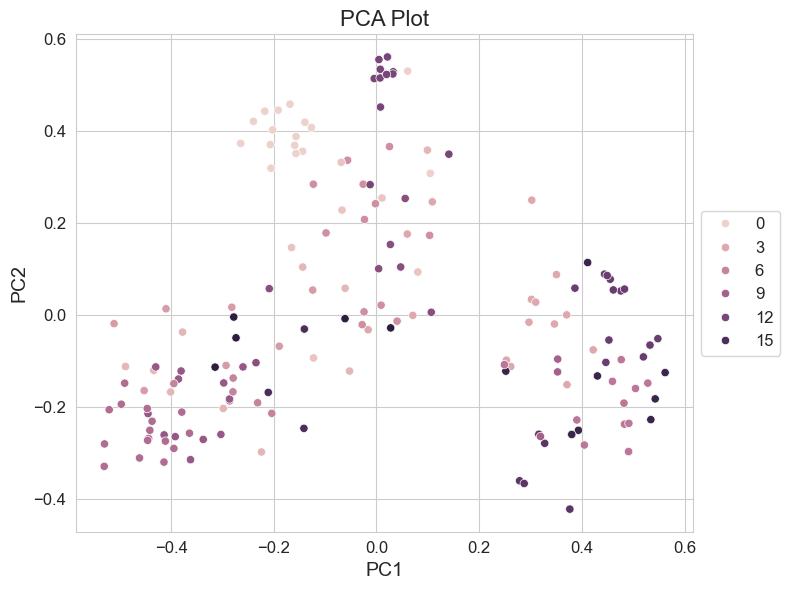

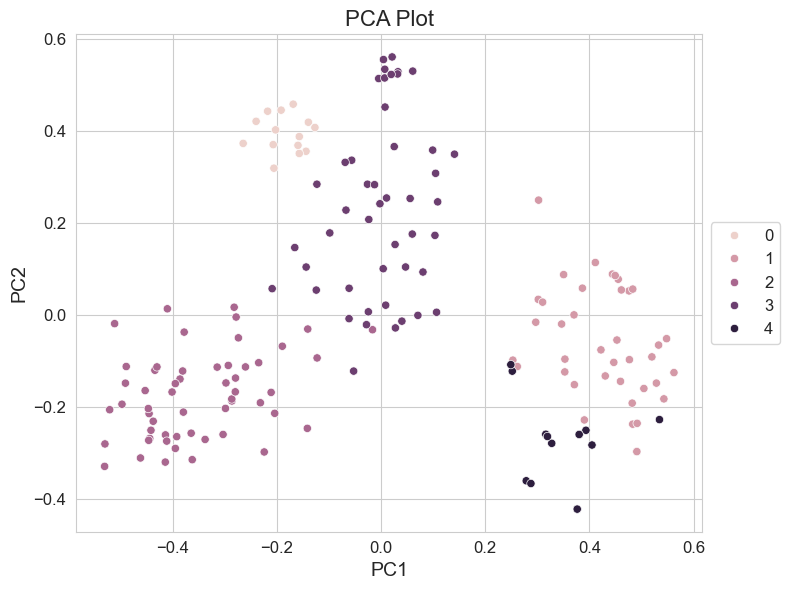

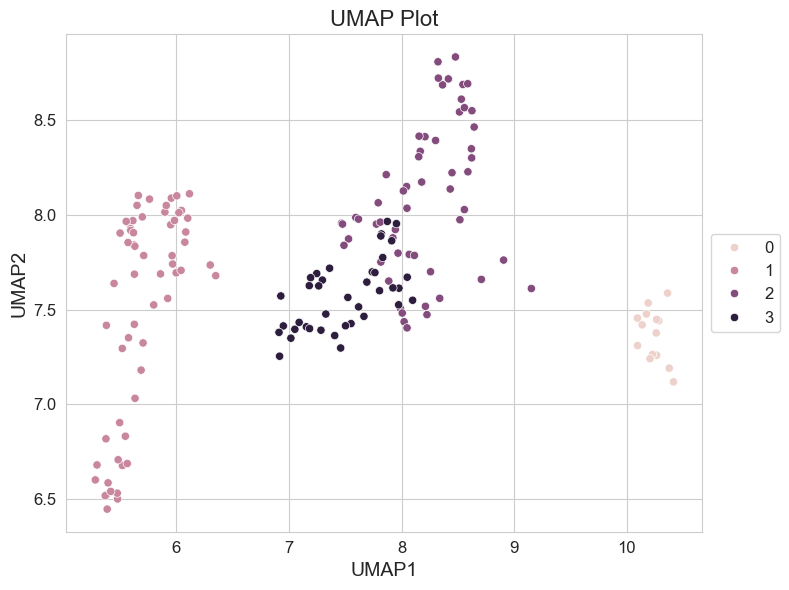

In [189]:
#Make optimal clusters corresponding to the Silhoutte coefficient found in the above plots for each of the cases. And then visualise them using PCA or UMAP.

#Case 1
n_cluster = 18
emb_split_df, kmeans_pl = models.cluster_data(embedding_prefix='embedding_', n_clusters=n_cluster)
#Plotter.plot_pca(emb_split_df, ='klabels')
Plotter.plot_pca(emb_split_df, filename='pca_emb_klabels_'+str(n_cluster)+'.png', hue='klabels')

#Case 2
n_cluster_pca = 5
emb_split_df, kmeans_pl = models.cluster_data(embedding_prefix='PC', n_clusters=n_cluster_pca)
Plotter.plot_pca(emb_split_df, filename='pca_PCemb_klabels_'+str(n_cluster)+'.png', hue='klabels')

#Case 3
n_cluster_umap = 4
emb_split_df, kmeans_pl = models.cluster_data(embedding_prefix='UMAP', n_clusters=n_cluster_umap)
Plotter.plot_umap(emb_split_df, filename='umap_UMAPemb_klabels_'+str(n_cluster)+'.png', hue='klabels')

In [190]:
# Save cluster centroids in FAISS
centroid_index = models.get_centroid_indices()

#save embeddings of products in a dictionary with keys corresponding to their cluster centroid. 
cluster_index_dict = models.save_faiss_index_by_label('UMAP')

In [191]:
reco_update = RecoUpdate()

# Recommend a product
reco_update.recommend_catalog(query_string='chocolate')['title']

158     Halba Creamy Milk Chocolate Hearts
125         Halba Chocolate Bar Milk Extra
164    Halba Chocolate Bar Dark Pistachios
Name: title, dtype: object

In [153]:
#Update the catalog in realtime
title = 'Dettol Liquid hand sanitizer'
typ = 'clean'
quantity = '40gm'
price = 2.0

reco_update.update_catalog(title,typ,quantity,price)

In [154]:
#Recommend a product with upadted catalog
reco_update.recommend_catalog(query_string='Dettol Liquid hand sanitizer')['title']

67        FREE - Neo Dolce Gusto Recycling Bag
1                      Dove Deo Spray Original
37    well Vanilla & coconut cream soap Refill
Name: title, dtype: object